In [ ]:
import os
import time
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

import tensorflow as tf

print(tf.__version__)

if tf.test.is_gpu_available():
    from tensorflow.keras.layers import CuDNNLSTM as LSTM, CuDNNGRU as GRU
else:
    print("GPU is not available")
    from tensorflow.keras.layers import LSTM, GRU

DATA_DIR = "/content/data"
FILE = "NFLX.csv"
PATH = os.path.join(DATA_DIR, FILE)

WINDOW = 100
FEATURE_NAMES = ["High", "Low", "Open", "Close", "Volume", "10ma", "30ma"]
BATCH_SIZE = 64
EPOCHS = 20

1.14.0


In [ ]:
# download and / or import data

from pandas_datareader.data import DataReader

YEARS = 5  # how many years of data to download
NAME = "NFLX"
DATA_SOURCE = "yahoo"

if os.path.exists(PATH):
    df = pd.read_csv(PATH)
    df.set_index("Date", inplace=True)
else:
    dt = datetime.datetime.now()
    df = DataReader(NAME, DATA_SOURCE, start=dt-relativedelta(years=YEARS), end=dt)

    if not os.path.isdir(DATA_DIR):
        os.makedirs(DATA_DIR)
    df.to_csv(PATH)

df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-22,65.278572,62.697144,65.181427,63.254284,16169300.0,63.254284
2014-09-23,64.001427,62.928570,63.032856,63.414288,11471600.0,63.414288
2014-09-24,64.522858,63.220001,63.494286,64.365715,9551500.0,64.365715
2014-09-25,64.621429,63.202858,64.271431,63.355713,9839900.0,63.355713
2014-09-26,64.377144,63.412857,63.571430,64.107140,10404800.0,64.107140


In [ ]:
# preprocessing pipeline

from sklearn.base import BaseEstimator, TransformerMixin

class FeatureUpdater(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        assert isinstance(X, pd.DataFrame)
        assert "Close" in X.columns

        if "Adj Close" in X.columns:
            X_copy = X.drop("Adj Close", axis=1)
        else:
            X_copy = X.copy()
        X_copy["10ma"] = X_copy["Close"].rolling(window=10).mean()
        X_copy["30ma"] = X_copy["Close"].rolling(window=30).mean()

        return X_copy

class NanDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            return X.dropna(axis=0)
        return pd.DataFrame(X).dropna(axis=0)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ("feature_updater", FeatureUpdater()),
    ("nan_dropper", NanDropper()),
    ("scaler", MinMaxScaler())
])

df_tr = pd.DataFrame(pipeline.fit_transform(df), columns=FEATURE_NAMES)

df_tr.head()

,High,Low,Open,Close,Volume,10ma,30ma
0,0.025150,0.026576,0.025368,0.029174,0.183252,0.020205,0.035485
1,0.025814,0.027007,0.028723,0.027508,0.155173,0.021367,0.034735
2,0.022676,0.024546,0.026326,0.025356,0.094994,0.022035,0.033892
3,0.022900,0.023622,0.025828,0.024439,0.116922,0.022263,0.032924
4,0.021947,0.023994,0.022937,0.025555,0.081407,0.022273,0.032094


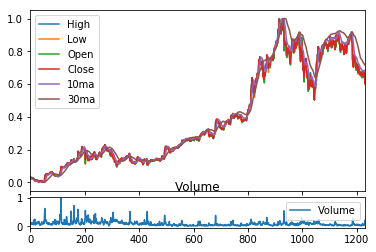

In [ ]:
# plot data

def plot_data(df):
    ax1 = plt.subplot2grid(shape=(6, 1), loc=(0, 0), rowspan=5)
    ax2 = plt.subplot2grid(shape=(6, 1), loc=(5, 0), sharex=ax1)

    df.plot(y=["High", "Low", "Open", "Close", "10ma", "30ma"], ax=ax1)
    df.plot(y="Volume", ax=ax2, title="Volume")

    plt.show()

plot_data(df_tr)

In [ ]:
# split data into training, validation and test sets

"""
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=TEST_RATIO)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=VALIDATION_RATIO)
"""

TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.15

def split_input_output(df, target_feature="Open"):
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df, columns=FEATURE_NAMES)
    X = np.array([df.iloc[i : i + WINDOW, :].values for i in range(len(df) - WINDOW)])
    y = np.expand_dims(df[target_feature][WINDOW:].values, axis=1)
    return X, y

def split_train_val_test(X, y):
    assert X.shape[0] == y.shape[0]

    train_val_split = int(TRAIN_RATIO * X.shape[0])
    val_test_split = int((TRAIN_RATIO + VALIDATION_RATIO) * X.shape[0])

    train_X = X[:train_val_split]
    train_y = y[:train_val_split]
    val_X = X[train_val_split : val_test_split]
    val_y = y[train_val_split : val_test_split]
    test_X = X[val_test_split:]
    test_y = y[val_test_split:]

    return train_X, train_y, val_X, val_y, test_X, test_y

X, y = split_input_output(df_tr)
train_X, train_y, val_X, val_y, test_X, test_y = split_train_val_test(X, y)

print("Training input shape: ", train_X.shape)
print("Training output shape: ", train_y.shape)
print("Validation input shape: ", val_X.shape)
print("Validation ouput shape: ", val_y.shape)
print("Test input shape: ", test_X.shape)
print("Test output shape: ", test_y.shape)

Training input shape:  (791, 100, 7)
Training output shape:  (791, 1)
Validation input shape:  (169, 100, 7)
Validation ouput shape:  (169, 1)
Test input shape:  (170, 100, 7)
Test output shape:  (170, 1)


In [ ]:
# the models and tensorboard logs will be saved to the following folders

LOG_DIR = "/content/logs"
MODEL_DIR = "/content/models"

if not os.path.isdir(LOG_DIR):
    os.makedirs(LOG_DIR)

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [ ]:
# feedforward neural network

name_ffnn = "FFNN-" + str(int(time.time()))

model_ffnn = Sequential([
    Flatten(input_shape=train_X.shape[1:]),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1)
])
model_ffnn.compile(optimizer="adam", loss="mse")

model_ffnn.summary()

history_ffnn = model_ffnn.fit(train_X, train_y, validation_data=(val_X, val_y), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[TensorBoard(log_dir=os.path.join(LOG_DIR, name_ffnn))])

model_ffnn.evaluate(test_X, test_y)

model_ffnn.save(os.path.join(MODEL_DIR, name_ffnn + ".h5"))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 700)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               89728     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Tota

In [ ]:
# lstm

name_lstm = "LSTM-" + str(int(time.time()))

model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(None, train_X.shape[2])),  # accept input of arbitary length
    Dropout(0.2),
    
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    
    LSTM(128),
    Dropout(0.2),
    
    Flatten(),

    Dense(64),
    Dropout(0.2),

    Dense(1)
])
model_lstm.compile(optimizer=Adam(lr=0.001, decay=1e-6), loss="mse")

model_lstm.summary()

history_lstm = model_lstm.fit(train_X, train_y, validation_data=(val_X, val_y), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[TensorBoard(log_dir=os.path.join(LOG_DIR, name_lstm))])

model_lstm.evaluate(test_X, test_y)

model_lstm.save(os.path.join(MODEL_DIR, name_lstm + ".h5"))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, None, 128)         70144     
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, None, 128)         132096    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

In [ ]:
# gru

name_gru = "GRU-" + str(int(time.time()))

model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(None, train_X.shape[2])),  # accept input of arbitary length
    Dropout(0.2),
    
    GRU(128, return_sequences=True),
    Dropout(0.2),
    
    GRU(128),
    Dropout(0.2),
    
    Flatten(),

    Dense(64),
    Dropout(0.2),

    Dense(1)
])
model_gru.compile(optimizer=Adam(lr=0.001, decay=1e-6), loss="mse")

model_gru.summary()

history_gru = model_gru.fit(train_X, train_y, validation_data=(val_X, val_y), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[TensorBoard(log_dir=os.path.join(LOG_DIR, name_gru))])

model_gru.evaluate(test_X, test_y)

model_gru.save(os.path.join(MODEL_DIR, name_gru + ".h5"))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru (CuDNNGRU)         (None, None, 128)         52608     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

In [ ]:
# 1d cnn

name_cnn = "CNN-" + str(int(time.time()))

model_cnn = Sequential([
    Conv1D(128, 2, use_bias=True, activation="relu", kernel_initializer="VarianceScaling", input_shape=train_X.shape[1:]),
    AveragePooling1D(strides=1),

    Conv1D(64, 2, use_bias=True, activation="relu", kernel_initializer="VarianceScaling"),
    AveragePooling1D(strides=1),

    Conv1D(32, 2, use_bias=True, activation="relu", kernel_initializer="VarianceScaling"),
    AveragePooling1D(strides=1),

    Flatten(),

    Dense(256, activation="relu"),
    Dense(1)
])
model_cnn.compile(optimizer="adam", loss="mse")

model_cnn.summary()

history_cnn = model_cnn.fit(train_X, train_y, validation_data=(val_X, val_y), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[TensorBoard(log_dir=os.path.join(LOG_DIR, name_cnn))])

model_cnn.evaluate(test_X, test_y)

model_cnn.save(os.path.join(LOG_DIR, name_cnn + ".h5"))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 99, 128)           1920      
_________________________________________________________________
average_pooling1d (AveragePo (None, 98, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 97, 64)            16448     
_________________________________________________________________
average_pooling1d_1 (Average (None, 96, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 95, 32)            4128      
_________________________________________________________________
average_pooling1d_2 (Average (None, 94, 32)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3008)             

In [ ]:
# visualise model predictions

def visualize_predictions(days, actual, models, X, labels):
    assert len(models) == len(labels)

    plt.plot(days, actual, label="Actual Price")
    for i, model in enumerate(models):
        plt.plot(days, model.predict(X), label=labels[i])
    plt.legend()
    plt.show()

visualize_predictions(
    days=df_tr.index[WINDOW:].values,
    actual=y,
    models=[model_ffnn, model_lstm, model_gru, model_cnn],
    X=X,
    labels=["FFNN", "LSTM", "GRU", "CNN"]
)

NameError: ignored

In [ ]:
# plot model losses and training

def plot_losses(histories, labels):
    assert len(histories) == len(labels)

    ax_loss = plt.subplot2grid(shape=(1, 2), loc=(0, 0))
    ax_val_loss = plt.subplot2grid(shape=(1, 2), loc=(0, 1))

    for i, history in enumerate(histories):
        ax_loss.plot(range(EPOCHS), history.history["loss"], label=labels[i])
        ax_val_loss.plot(range(EPOCHS), history.history["val_loss"], label=labels[i])
    ax_loss.legend()
    ax_val_loss.legend()

    plt.show()

plot_losses(
    histories=[history_ffnn, history_lstm, history_gru, history_cnn],
    labels=["FFNN", "LSTM", "GRU", "CNN"]
)

NameError: ignored

In [ ]:
# experimenting with different architectures for the lstm

lstm_sizes = [256, 512]
lstm_layer_nums = [1, 2, 3]
dropout_rates = [0, 0.2, 0.4]
dense_sizes = [256, 512]

for lstm_size in lstm_sizes:
    for lstm_layer_num in lstm_layer_nums:
        for dropout_rate in dropout_rates:
            for dense_size in dense_sizes:
                name = f"LSTM-{lstm_size}-{lstm_layer_num}-{dropout_rate}-{dense_size}-{int(time.time())}"

                model = Sequential()

                if lstm_layer_num == 1:
                    model.add(LSTM(lstm_size, input_shape=(None, train_X.shape[2])))
                    model.add(Dropout(dropout_rate))
                else:
                    model.add(LSTM(lstm_size, return_sequences=True, input_shape=(None, train_X.shape[2])))
                    model.add(Dropout(dropout_rate))

                    for _ in range(lstm_layer_num - 2):
                        model.add(LSTM(lstm_size, return_sequences=True))
                        model.add(Dropout(dropout_rate))
                    
                    model.add(LSTM(lstm_size))
                    model.add(Dropout(dropout_rate))
                    
                model.add(Flatten())

                model.add(Dense(dense_size))
                model.add(Dropout(dropout_rate))

                model.add(Dense(1))

                model.compile(optimizer=Adam(lr=0.001, decay=1e-6), loss="mse")

                model.fit(
                    train_X,
                    train_y,
                    validation_data=(val_X, val_y),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[TensorBoard(log_dir=os.path.join(LOG_DIR, name))],
                    verbose=0
                )

                loss = model.evaluate(test_X, test_y, verbose=0)
                print(name.ljust(37), loss)

                model.save(os.path.join(MODEL_DIR, name + ".h5"))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
LSTM-256-1-0-256-1569067585           0.000771384166471441
LSTM-256-1-0-512-1569067602           0.0005244185411891736
LSTM-256-1-0.2-256-1569067615         0.0013613891733043333
LSTM-256-1-0.2-512-1569067627         0.00048368569148485275
LSTM-256-1-0.4-256-1569067640         0.0005854476181625882
LSTM-256-1-0.4-512-1569067653         0.0004048840252353865
LSTM-256-2-0-256-1569067667           0.001741345419877154
LSTM-256-2-0-512-1569067694           0.001724570045959862
LSTM-256-2-0.2-256-1569067721         0.0017416157424176002
LSTM-256-2-0.2-512-1569067750         0.0013493808801285923
LSTM-256-2-0.4-256-1569067778         0.0007730655355022892
LSTM-256-2-0.4-512-1569067807         0.002853274502901032
LSTM-256-3-0-256-1569067836           0.0014699550619458452
LSTM-256-3-0-512-1569067880           0.01192138028495452
LSTM-256-3-0.2-256-1569067924         0.0011336

We will now use tensorboard to compare the models. This notebook was run on google colab to train the models using a hosted gpu server, and hence localtunnel is used to help run tensorboard.

In [ ]:
# install localtunnel

!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.0
added 35 packages from 21 contributors in 2.303s


In [ ]:
# tensorboard

get_ipython().system_raw(f'tensorboard --logdir {LOG_DIR} --host 0.0.0.0 --port 6006 &')
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

!cat url.txt

your url is: https://ordinary-hound-56.localtunnel.me
/tools/node/lib/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:36158 (check your firewall settings)
    at Socket.remote.on.err (/tools/node/lib/node_modules/localtunnel/lib/TunnelCluster.js:52:11)
    at emitOne (events.js:116:13)
    at Socket.emit (events.js:211:7)
    at emitErrorNT (internal/streams/destroy.js:64:8)
    at _combinedTickCallback (internal/process/next_tick.js:138:11)
    at process._tickCallback (internal/process/next_tick.js:180:9)
your url is: https://odd-parrot-5.localtunnel.me
your url is: https://mean-falcon-4.localtunnel.me
/tools/node/lib/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:41770 (check your firewall settings)
    at Socket.remote.on.err (/tools/node/lib/node_modules/localtunnel/lib/TunnelCluster.js:52:11)
    at emitOne (events.js:116:13)
    at Socket.emit (events.js:211:7)
    at emi

It is apparent that the model with 256 lstm nodes, 1 lstm layer, a dropout rate of 0.4 and with 512 dense layers produces the best results, with the lowest test and validation losses (0.00042 and 0.00100 respectively)

In [ ]:
BEST_MODEL = os.path.join(MODEL_DIR, "LSTM-256-1-0.4-512-1568463412.h5")  # change the model name if the timestamp is different

In [ ]:
# download the best model

from google.colab import files

files.download(BEST_MODEL)

In [ ]:
# test the final model on other companies' stocks

def test_company(name):
    dt = datetime.datetime.now()
    df = DataReader(name, "yahoo", start=dt-relativedelta(years=5), end=dt)
    df_tr = pd.DataFrame(pipeline.fit_transform(df), columns=FEATURE_NAMES)
    X, y = split_input_output(df_tr)

    model = tf.keras.models.load_model(BEST_MODEL)
    model.evaluate(X, y)

    visualize_predictions(
        days=df_tr.index[WINDOW:].values,
        actual=y,
        models=[model],
        X=X,
        labels=["LSTM Predictions"],
    )

1130/1130 [==============================] - 0s 344us/sample - loss: 4.1550e-04


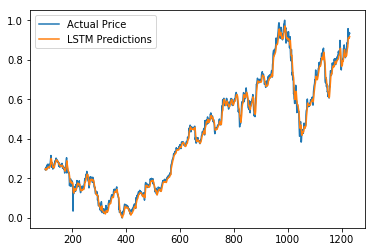

In [ ]:
# apple stocks

test_company("AAPL")

1130/1130 [==============================] - 0s 372us/sample - loss: 3.9997e-04


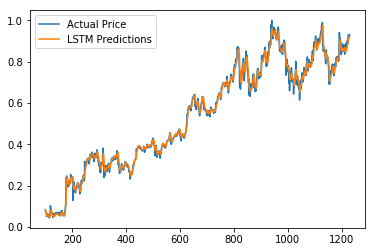

In [ ]:
# google stocks

test_company("GOOGL")

1130/1130 [==============================] - 0s 406us/sample - loss: 3.0817e-04


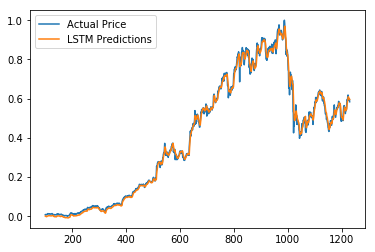

In [ ]:
# nvidia stocks

test_company("NVDA")

1130/1130 [==============================] - 0s 435us/sample - loss: 8.5428e-04


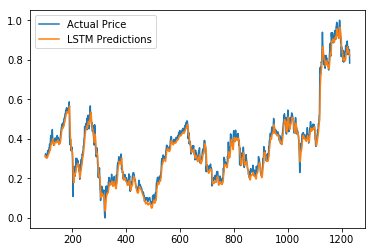

In [ ]:
# disney stocks

test_company("DIS")

1125/1125 [==============================] - 1s 454us/sample - loss: 3.0266e-04


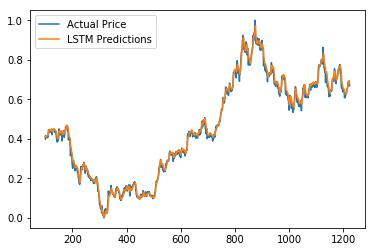

In [ ]:
# dbs stocks

test_company("D05.SI")

It is apparent that the model generates accurate predictions even for the stock prices of other companies it was not trained on.

In [ ]:
# get the actual price and predictions

def unscale_price(data, feature="Open"):
    """data is a 1-D array of opening prices"""
    scaler = pipeline.named_steps["scaler"]
    scaler_copy = MinMaxScaler()
    col_no = FEATURE_NAMES.index(feature)
    scaler_copy.min_, scaler_copy.scale_ = scaler.min_[col_no], scaler.scale_[col_no]
    return scaler_copy.inverse_transform(data)

def test_company_table(name):
    dt = datetime.datetime.now()
    df = DataReader(name, "yahoo", start=dt-relativedelta(years=5), end=dt)
    df_tr = pd.DataFrame(pipeline.fit_transform(df), columns=FEATURE_NAMES)
    X, y = split_input_output(df_tr)

    model = tf.keras.models.load_model(BEST_MODEL)  # change the model name if the timestamp is different
    predictions_unscaled = unscale_price(model.predict(X)).flatten()
    actual_unscaled = unscale_price(y).flatten()

    table = pd.DataFrame({"Date": df.index[WINDOW + 29:].values, "Predicted": predictions_unscaled, "Actual": actual_unscaled})
    table.set_index("Date", inplace=True)
    return table

In [ ]:
nflx_table = test_company_table("NFLX")
nflx_table.head()

,Predicted,Actual
Date,,
2015-03-27,58.167995,59.330002
2015-03-30,57.471416,59.715714
2015-03-31,57.224842,60.110001
2015-04-01,57.108532,59.642857
2015-04-02,56.827667,59.071430


In [ ]:
# mean absolute error

np.mean(np.abs(nflx_table["Predicted"] - nflx_table["Actual"]))

6.5992601824801005

As you can see, the actual error of the model in terms of money is around 20 cents, which is too high and not practical in stock trading.

However, predicting the range of prices for that day (the high and low prices) would be more useful as valuable information can still be obtained even if those predictions are not accurate.

We will now modify the lstm model to predict the highest and lowest prices of the day. A separate model will be trained for each feature.

Train on 791 samples, validate on 169 samples
Epoch 1/20
791/791 [==============================] - 1s 1ms/sample - loss: 0.0159 - val_loss: 0.0018
Epoch 2/20
791/791 [==============================] - 0s 229us/sample - loss: 0.0031 - val_loss: 0.0041
Epoch 3/20
791/791 [==============================] - 0s 203us/sample - loss: 0.0018 - val_loss: 0.0022
Epoch 4/20
791/791 [==============================] - 0s 208us/sample - loss: 0.0013 - val_loss: 0.0016
Epoch 5/20
791/791 [==============================] - 0s 203us/sample - loss: 0.0012 - val_loss: 0.0018
Epoch 6/20
791/791 [==============================] - 0s 202us/sample - loss: 9.1537e-04 - val_loss: 0.0014
Epoch 7/20
791/791 [==============================] - 0s 204us/sample - loss: 9.9727e-04 - val_loss: 0.0014
Epoch 8/20
791/791 [==============================] - 0s 205us/sample - loss: 9.8865e-04 - val_loss: 0.0013
Epoch 9/20
791/791 [==============================] - 0s 202us/sample - loss: 9.5909e-04 - val_loss: 0.0031
Epoc

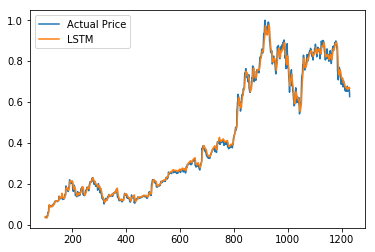

In [ ]:
# model to predict day high

X, y = split_input_output(df_tr, target_feature="High")
train_X, train_y, val_X, val_y, test_X, test_y = split_train_val_test(X, y)

model_high = Sequential([
    LSTM(256, input_shape=(None, train_X.shape[2])),
    Dropout(0.4),

    Flatten(),

    Dense(512),
    Dropout(0.4),

    Dense(1)
])
model_high.compile(optimizer=Adam(lr=0.001, decay=1e-6), loss="mse")

model_high.fit(train_X, train_y, validation_data=(val_X, val_y), batch_size=BATCH_SIZE, epochs=EPOCHS)

model_high.evaluate(test_X, test_y)

model_high.save(os.path.join(MODEL_DIR, "LSTM-high.h5"))

# plot predictions

visualize_predictions(
    days=df_tr.index[WINDOW:].values,
    actual=y,
    models=[model_high],
    X=X,
    labels=["LSTM"]
)

Train on 791 samples, validate on 169 samples
Epoch 1/20
791/791 [==============================] - 1s 2ms/sample - loss: 0.0231 - val_loss: 0.0217
Epoch 2/20
791/791 [==============================] - 0s 246us/sample - loss: 0.0035 - val_loss: 0.0108
Epoch 3/20
791/791 [==============================] - 0s 227us/sample - loss: 0.0020 - val_loss: 0.0030
Epoch 4/20
791/791 [==============================] - 0s 204us/sample - loss: 0.0016 - val_loss: 0.0020
Epoch 5/20
791/791 [==============================] - 0s 205us/sample - loss: 0.0015 - val_loss: 0.0029
Epoch 6/20
791/791 [==============================] - 0s 202us/sample - loss: 0.0012 - val_loss: 0.0047
Epoch 7/20
791/791 [==============================] - 0s 204us/sample - loss: 0.0014 - val_loss: 0.0025
Epoch 8/20
791/791 [==============================] - 0s 207us/sample - loss: 0.0011 - val_loss: 0.0017
Epoch 9/20
791/791 [==============================] - 0s 205us/sample - loss: 0.0012 - val_loss: 0.0020
Epoch 10/20
791/791 

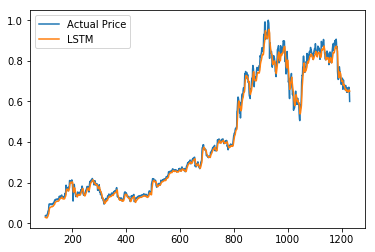

In [ ]:
# model to predict day low

X, y = split_input_output(df_tr, target_feature="Low")
train_X, train_y, val_X, val_y, test_X, test_y = split_train_val_test(X, y)

model_low = Sequential([
    LSTM(256, input_shape=(None, train_X.shape[2])),
    Dropout(0.4),

    Flatten(),

    Dense(512),
    Dropout(0.4),

    Dense(1)
])
model_low.compile(optimizer=Adam(lr=0.001, decay=1e-6), loss="mse")

model_low.fit(train_X, train_y, validation_data=(val_X, val_y), batch_size=BATCH_SIZE, epochs=EPOCHS)

model_low.evaluate(test_X, test_y)

model_low.save(os.path.join(MODEL_DIR, "LSTM-low.h5"))

# plot predictions

visualize_predictions(
    days=df_tr.index[WINDOW:].values,
    actual=y,
    models=[model_low],
    X=X,
    labels=["LSTM"]
)

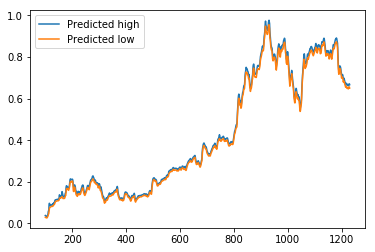

In [ ]:
plt.plot(df_tr.index[WINDOW:].values, model_high.predict(X), label="Predicted high")
plt.plot(df_tr.index[WINDOW:].values, model_low.predict(X), label="Predicted low")
plt.legend()
plt.show()

In [ ]:
# model to predict the high and low of the next 10 days
# the number of output neurons is now 20, which may affect the accuracy of the model

NEXT = 10

X = np.array([df_tr.iloc[i : i + WINDOW, :].values for i in range(len(df_tr) - WINDOW - NEXT)])
y = np.array([df_tr.loc[i + WINDOW : i + WINDOW + NEXT - 1, ["High", "Low"]].values for i in range(len(df_tr) - WINDOW - NEXT)])

print(X[:5])
print(y[:5])

[[[0.0251502  0.02657588 0.02536826 ... 0.18325192 0.02020532 0.03548474]
  [0.02581434 0.02700677 0.02872307 ... 0.15517288 0.02136674 0.03473482]
  [0.02267579 0.02454561 0.02632569 ... 0.09499381 0.02203479 0.0338918 ]
  ...
  [0.04333636 0.0435905  0.04191442 ... 0.14844398 0.04105003 0.0496866 ]
  [0.04225476 0.04121474 0.04603291 ... 0.19474343 0.04031633 0.04924247]
  [0.03629264 0.03889333 0.0379061  ... 0.14018425 0.0391203  0.04873724]]

 [[0.02581434 0.02700677 0.02872307 ... 0.15517288 0.02136674 0.03473482]
  [0.02267579 0.02454561 0.02632569 ... 0.09499381 0.02203479 0.0338918 ]
  [0.0228997  0.02362171 0.02582798 ... 0.11692226 0.02226277 0.03292381]
  ...
  [0.04225476 0.04121474 0.04603291 ... 0.19474343 0.04031633 0.04924247]
  [0.03629264 0.03889333 0.0379061  ... 0.14018425 0.0391203  0.04873724]
  [0.03469869 0.03667285 0.03711205 ... 0.13836765 0.0381801  0.04815849]]

 [[0.02267579 0.02454561 0.02632569 ... 0.09499381 0.02203479 0.0338918 ]
  [0.0228997  0.023621

In [ ]:
train_X, train_y, val_X, val_y, test_X, test_y = split_train_val_test(X, y.reshape(y.shape[0], -1))

model_next = Sequential([
    LSTM(256, input_shape=(None, train_X.shape[2])),
    Dropout(0.4),

    Flatten(),

    Dense(512),
    Dropout(0.4),

    Dense(NEXT * 2)
])

model_next.compile(optimizer=Adam(lr=0.001, decay=1e-6), loss="mse")

model_next.fit(train_X, train_y, validation_data=(val_X, val_y), batch_size=BATCH_SIZE, epochs=EPOCHS)

model_next.evaluate(test_X, test_y)

model_next.save(os.path.join(MODEL_DIR, f"LSTM-next-{NEXT}-high-low.h5"))

Train on 784 samples, validate on 168 samples
Epoch 1/20
784/784 [==============================] - 2s 2ms/sample - loss: 0.0217 - val_loss: 0.0083
Epoch 2/20
784/784 [==============================] - 0s 254us/sample - loss: 0.0051 - val_loss: 0.0070
Epoch 3/20
784/784 [==============================] - 0s 211us/sample - loss: 0.0037 - val_loss: 0.0051
Epoch 4/20
784/784 [==============================] - 0s 216us/sample - loss: 0.0030 - val_loss: 0.0050
Epoch 5/20
784/784 [==============================] - 0s 209us/sample - loss: 0.0028 - val_loss: 0.0049
Epoch 6/20
784/784 [==============================] - 0s 209us/sample - loss: 0.0026 - val_loss: 0.0049
Epoch 7/20
784/784 [==============================] - 0s 212us/sample - loss: 0.0023 - val_loss: 0.0049
Epoch 8/20
784/784 [==============================] - 0s 215us/sample - loss: 0.0022 - val_loss: 0.0049
Epoch 9/20
784/784 [==============================] - 0s 215us/sample - loss: 0.0022 - val_loss: 0.0048
Epoch 10/20
784/784 

As you can see, the accuracy of the model is clearly affected due to the higher amount of predictions and hence greater complexity, thus a larger model may be required to make accurate predictions futher into the future.

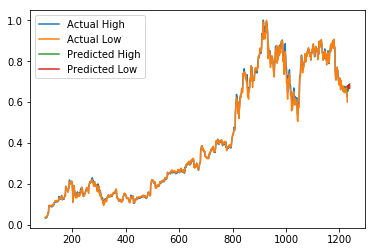

In [ ]:
predicted = model_next.predict(np.expand_dims(df_tr.iloc[-100:, :].values, axis=0)).flatten()
high = predicted[:NEXT]
low = predicted[NEXT:]

plt.plot(df_tr.index[WINDOW:].values, df_tr["High"][WINDOW:].values, label="Actual High")
plt.plot(df_tr.index[WINDOW:].values, df_tr["Low"][WINDOW:].values, label="Actual Low")
plt.plot(range(df_tr.index[-1], df_tr.index[-1] + NEXT), high, label="Predicted High")
plt.plot(range(df_tr.index[-1], df_tr.index[-1] + NEXT), low, label="Predicted Low")
plt.legend()
plt.show()

In [ ]:
pipeline.fit(df)
high_low_predictions_df = pd.DataFrame({"High": unscale_price(np.expand_dims(high, axis=1), feature="High").flatten(),
                                        "Low": unscale_price(np.expand_dims(low, axis=1), feature="Low").flatten()})
high_low_predictions_df

,High,Low
0,302.169800,293.899261
1,296.907776,293.083130
2,292.739288,295.500458
3,296.282959,294.505859
4,303.337860,294.262360
5,299.599915,291.348450
6,300.364197,297.488983
7,297.884888,290.553009
8,301.414459,296.423737
9,305.891571,290.927673


In [ ]:
# predict the next day's opening price

model_lstm = tf.keras.models.load_model(BEST_MODEL)
pipeline.fit(df)
unscale_price(model_lstm.predict(np.expand_dims(df_tr.iloc[-100:, :].values, axis=0)))

array([[287.181]], dtype=float32)

In [ ]:
# sentiment analysis

import tweepy
from textblob import TextBlob

CONSUMER_KEY = ""  # missing; the code therefore cannot run
CONSUMER_SECRET = ""
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

In [ ]:
THRESHOLD = 0

score = 0

public_tweets = api.search("Facebook")
for tweet in public_tweets:
    analysis = TextBlob(tweet.text)
    if analysis.sentiment.polarity >= THRESHOLD:
        score += 1
    else:
        score -= 1

score

TweepError: ignored